## Analysis notebook for atmosphere NetCDF files

### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
import pandas as pd
from cmcrameri import cm

In [2]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [20]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

%matplotlib widget

In [4]:
def readncdf(f):

    ds = nc.Dataset(f)
    vars = list(ds.variables.keys())

    nlev_c = len(ds.variables ["p"][:])
    nlev_l = len(ds.variables["pl"][:])
    tsurf  = float(ds.variables["tmp_surf"][:])
    psurf  = float(ds.variables["pl"][-1])
    gases  = [str(bytearray(s).decode()).strip() for s in ds.variables["gases"][:]]
    asf    = float(ds.variables["toa_heating"][:])

    data = {
        "nlev_c":       nlev_c,
        "nlev_l":       nlev_l,
        "tmp_surf":     tsurf,
        "psurf":        psurf,
        "gases":        gases,
        "toa_heating":  asf,
    }

    for k in vars:
        if k in data.keys():
            continue
        var = ds.variables[k][:]
        try:
            data[k] = np.array(ds.variables[k][:], dtype=float)
        except:
            continue

    ds.close()
    return data

def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]
    mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')

def read_postproc(f):
    ds = nc.Dataset(f+"/ppr.nc")
    vars = list(ds.variables.keys())

    data = {}
    for k in vars:
        if k in data.keys():
            continue
        try:
            data[k] = np.array(ds.variables[k][:], dtype=float)
        except:
            continue

    data["nsamps"] = len(ds.dimensions["nsamps"])
    data["nbands"] = len(ds.dimensions["nbands"])

    data["original_model"] = str(ds.original_model)

    ds.close()
    return data


### Do analysis

In [5]:
outname = "hd63433d_v5"
stride = 2

In [6]:
globber = os.path.join(os.environ.get("HOME"),"PROTEUS","output",outname) + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
for folder in cases:
    y,d = readrun(folder, stride=stride)
    data.append( (y,d) )
    conf.append( read_config(folder+"init_coupler.toml") )
    help.append( read_helpfile(folder+"runtime_helpfile.csv") )
    post.append( read_postproc(folder) )
print("Done")

/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_*/
npoints = 22
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00000/'...
    Done reading 100 files
    Final time = 5.155e+05 years
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00001/'...
    Done reading 95 files
    Final time = 6.181e+05 years
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00002/'...
    Done reading 88 files
    Final time = 7.495e+05 years
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00003/'...
    Done reading 85 files
    Final time = 1.280e+06 years
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00004/'...
    Done reading 86 files
    Final time = 6.375e+06 years
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00005/'...
    Done reading 111 files
    Final time = 1.918e+06 years
Reading files in '/home/n/nichollsh/PROTEUS/output/hd63433d_v5/case_00006/'...
    Done reading 125 file

## Plot flux and meltfrac vs time

In [7]:
indep_var = "fO2_shift_IW"

indep_vals = set()
for i in range(npoints):
    indep_vals.add(conf[i][indep_var])

indep_max = np.amax(np.abs(list(indep_vals)))

In [8]:
cmap = cm.broc_r
norm = mpl.colors.Normalize(vmin=-indep_max, vmax=indep_max)
sm = plt.cm.ScalarMappable(cmap=cm.broc_r, norm=norm)

In [9]:
def add_cbar(fig):
    fig.subplots_adjust(right=0.83)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax, values=sorted(indep_vals))
    cbar.set_label(indep_var)

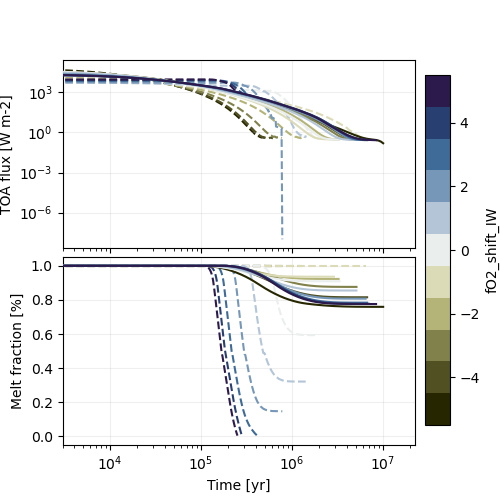

In [23]:
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(5,5))

for i in range(npoints):
    lbl = conf[i][indep_var]
    col = sm.to_rgba(float(lbl))

    ls = 'solid'
    if conf[i]["atmosphere_model"] == 0:
        ls='dashed'
        lbl = ""

    x1 = help[i]["Time"]
    y1 = np.array(help[i]["F_atm"])
    ax1.plot(x1,y1,label=lbl, linestyle=ls, c=col, zorder=i)

    x2 = help[i]["Time"]
    y2 = np.array(help[i]["Phi_global"])
    ax2.plot(x2,y2,linestyle=ls, c=col, zorder=i)


add_cbar(fig)

ax1.set_xscale("log")
ax1.set_xlim(left=3e3)
ax1.grid(zorder=-2, alpha=0.2)
ax2.grid(zorder=-2, alpha=0.2)
ax2.set_xlabel("Time [yr]")

ax1.set_yscale("log")
ax1.set_ylabel('TOA flux [W m-2]')

ax2.set_ylim(top=1.05, bottom=-0.05)
ax2.set_ylabel('Melt fraction [%]')

fig.subplots_adjust(hspace=0.05)
plt.show()

## Plot scalar quantities

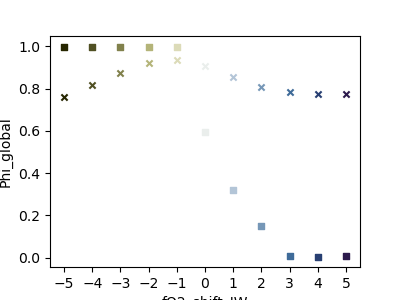

In [24]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(4,3))

y_key = "Phi_global"

ms = 20

x_vals = []

for i in range(npoints):
    y = help[i][y_key].iloc[-1]
    x = float(conf[i][indep_var])

    col = sm.to_rgba(x)
    marker = 's'
    if conf[i]["atmosphere_model"] != 0:
        marker = 'x'
        lbl = ""

    ax.scatter(x,y, marker=marker, color=col, s=ms)
    x_vals.append(x)

ax.set_xlabel(indep_var)
ax.set_ylabel(y_key)
ax.set_xticks(np.unique(x_vals))

plt.show()

## Plot highres spectra

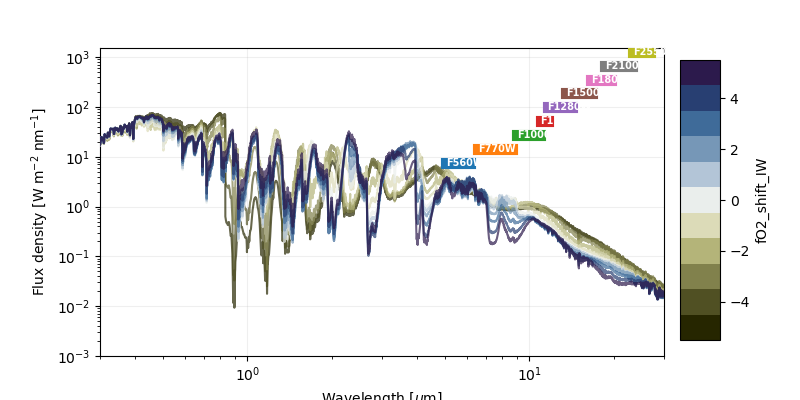

In [21]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(8,4))

instrument = "MIRI"

al=0.7
ymax = 1
for i in range(npoints):
    if conf[i]["atmosphere_model"] == 0:
        continue

    dat = post[i]

    lbl = conf[i]["fO2_shift_IW"]
    col = sm.to_rgba(float(lbl))
    ls = 'solid'

    x = (dat["bandmax"] + dat["bandmin"]) * 0.5 * 1e6
    w = np.abs(dat["bandmax"] - dat["bandmin"]) * 1e9
    y = (dat["ba_U_SW"][-1] + dat["ba_U_LW"][-1]) / w

    ymax = max(ymax, np.amax(y[2:]))
    ax.plot(x,y,label=lbl, linestyle=ls, c=col, zorder=i, alpha=al)

bands = observer_bands[instrument]
band_yspacing = 2.5
ytop = ymax*3
for i,b in enumerate(bands.keys()):
    v = bands[b]

    y = ymax * (10**(band_yspacing*i/len(bands.keys()) - 1))
    ytop = max(ytop, y*1.2)
    ax.plot(v, [y,y], lw=8, zorder=98)
    ax.text(v[0], y, b, fontsize=7, color='white', zorder=99, weight='bold',
            rotation=-0, horizontalalignment='left', verticalalignment='center')


add_cbar(fig)

ax.grid(zorder=-2, alpha=0.2)
ax.set_ylim(bottom=1e-3, top=ytop)

ax.set_xlabel(r"Wavelength [$\mu$m]")
ax.set_xlim(left=0.3, right=30)
ax.set_xscale("log")

ax.set_yscale("log")
ax.set_ylabel(r"Flux density [W m$^{-2}$ nm$^{-1}$]")

plt.show()

## Plot T(p) at endpoint

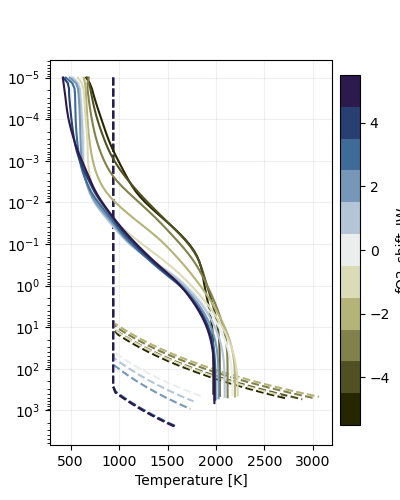

In [22]:
fig,ax = plt.subplots(1,1, sharex=True, figsize=(4,5))

for i in range(npoints):
    yrs = data[i][0]
    dat = data[i][1]

    lbl = conf[i]["fO2_shift_IW"]
    col = sm.to_rgba(float(lbl))
    ls = 'solid'
    if conf[i]["atmosphere_model"] == 0:
        lbl = ""
        ls='dashed'

    x = dat[len(yrs)-1]["tmpl"]
    y = dat[len(yrs)-1]["pl"] * 1e-5
    ax.plot(x,y,label=lbl, linestyle=ls, c=col, zorder=i)


add_cbar(fig)

ax.grid(zorder=-2, alpha=0.2)
ax.set_xlabel("Temperature [K]")
ax.invert_yaxis()
ax.set_yscale("log")
ax.set_ylabel('Pressure [bar]')

plt.show()

## Plot convective shutdown

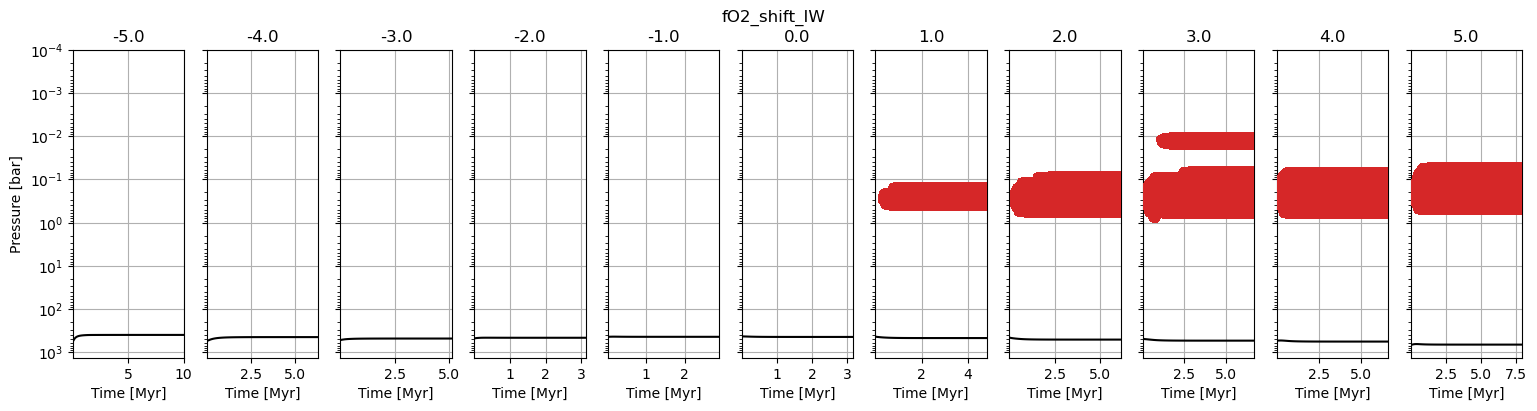

In [19]:
%matplotlib inline

nax = int(npoints/2)
fig,axs = plt.subplots(1,nax,figsize=(1.7*nax,4), sharey=True)

ymin = 1e-4
ymax = 1e1
xmin = 1.0e-5
xmax = 1

indep_stride = 2

itp_points = 100
interpolate = False
indep_var = "fO2_shift_IW"

c = 'tab:red'

# work out which indicies we want
idxs_plot = []
for i in range(npoints):
    if conf[i]["atmosphere_model"] != 0:
        idxs_plot.append(i)
indep_vals = [conf[i][indep_var] for i in idxs_plot]
mask = np.argsort(indep_vals)
idxs_plot = [idxs_plot[i] for i in mask]

iax = -1
for i in idxs_plot:
    iax += 1

    yrs = data[i][0]
    dat = data[i][1]

    psurf = []
    times = []

    mask_xs = []
    mask_ys = []
    mask_zs = []
    for j in range(len(yrs)):

        # time
        t = yrs[j]/1e6
        if t < xmin:
            continue
        times.append(t)

        # pressure array
        y = dat[j]["pl"]*1e-5
        psurf.append(np.amax(y))
        ymax = max(ymax, np.amax(y))

        # value to use as mask statistic
        val = abs(dat[j]["fl_cnvct"]/dat[j]["fl_tot"])
        conv_thresh = np.amin(np.abs(dat[j]["fl_N"][:]))

        # interpolate y and val
        if interpolate:
            itp = PchipInterpolator(y, val)
            y = np.logspace(np.log10(y[0]), np.log10(y[-1]), itp_points)
            val = itp(y)

        mask_zs.extend(list(val))
        mask_ys.extend(list(y))
        mask_xs.extend(list(np.ones(len(y))*t))

    axs[iax].tricontourf(mask_xs, mask_ys, mask_zs,
                levels=[-1, conv_thresh, 1e9], colors=[(0,0,0,0),c], zorder=3)

    axs[iax].plot(times, psurf, color='k', zorder=3)

    axs[iax].set_xlabel("Time [Myr]")
    axs[iax].set_title(conf[i][indep_var])
    axs[iax].grid(zorder=-1)

axs[0].set_ylim(top=ymin, bottom=ymax*2)
axs[0].set_yscale("log")
axs[0].set_ylabel("Pressure [bar]")

fig.suptitle(indep_var)
plt.show()
fig.savefig("nogit_convectmask.pdf", bbox_inches='tight')